In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xgboost as xgb
from CWAttack import CW
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# import torchattacks
# from torchattacks import CW


mnist_train = dsets.MNIST(root='./data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='./data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

batch_size = 128

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=batch_size,
                                         shuffle=False)

# X = pd.read_csv("../Research/mnist_train.csv")
# y = pd.read_csv("../Research/mnist_test.csv")

digits = load_digits()
train_data = digits.data
test_data = digits.target

print(train_data.shape)
print(test_data.shape)

(1797, 64)
(1797,)


In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

(1797, 64)


<Figure size 432x288 with 0 Axes>

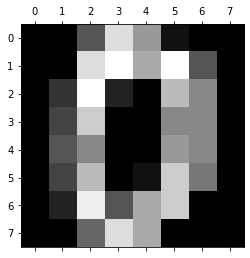

In [3]:
%matplotlib inline

print(digits.data.shape)

import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show()

60000
(60000, 784)


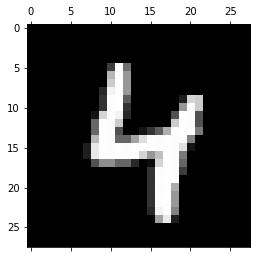

In [13]:
train_loader2  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=60000,
                                           shuffle=True)

test_loader2 = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=10000,
                                         shuffle=False)

for images, labels in train_loader2:
    images_np = images.numpy()
    images_re = images_np.reshape(images_np.shape[0],-1)
    labels_np = labels.numpy()
    print(images_np.shape[0])

for images, labels in test_loader2:
    images_test_np = images.numpy()
    images_test_re = images_test_np.reshape(images_test_np.shape[0],-1)
    labels_test_np = labels.numpy()
    print(images_re.shape)

plt.matshow(images_re[0].reshape(28,28)) 
plt.show()


# Train_est, Train_val = train_test_split(train_data, test_size=0.2, random_state=42)
# test_data_train, test_data_test = train_test_split(test_data, test_size=0.2, random_state=42)


# print(Train_est.shape)
# print(test_data_train.shape)

# print(Train_val.shape)
# print(test_data_test.shape)

In [5]:
dtrain = xgb.DMatrix(images_re, label=labels_np)
dtest = xgb.DMatrix(images_test_re, label=labels_test_np)
# print(dtest)
param = {
    'tree_method' : 'gpu_hist',
    'max_depth': 5,                 # the maximum depth of each tree
    'eta': 0.3,                     # the training step for each iteration
    'silent': 1,                    # logging mode - quiet
    'objective': 'multi:softmax',   # multiclass classification using the softmax objective
    'num_class': 10                 # the number of classes that exist in this datset
}  
num_round = 500  # the number of training iterations

In [6]:
# bstmodel = xgb.XGBClassifier(max_depth=5, learning_rate=0.3, n_estimators=500,
#                               silent=True, objective='multi:softmax', booster='gbtree')
bstmodel2 = xgb.train(param, dtrain, num_round)
#Save as human readable model
# bstmodel.dump_model('dump.raw.txt')

[14:42:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [8]:
# bstmodel.fit(Train_est, test_data_train)
# preds = bstmodel.predict(dtest)

preds = bstmodel2.predict(dtest)
print(preds.shape)

(10000,)


In [11]:
from sklearn import metrics
accuracy = metrics.accuracy_score(labels_test_np, preds)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.00%


In [ ]:
#Plotting tree does not work yet
#xgboost.plot_tree(bstmodel, num_trees=2)

# xgb.plot_importance(bstmodel)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# clf = xgb.XGBClassifier()
# parameters = {
#      "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#      "min_child_weight" : [ 1, 3, 5, 7 ],
#      "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#      "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
#      }

# grid = GridSearchCV(clf,
#                     parameters, n_jobs=4,
#                     scoring="neg_log_loss",
#                     cv=3)


# grid.fit(X_train, y_train)

In [12]:
def cw_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01) :

    images = images.to(device)     
    labels = labels.to(device)

    # Define f-function
    def f(x) :
        print(x.shape)
        lists = x[0][0].tolist()
        outputs = model.predict(x)
        print(outputs.shape)
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)

        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.byte())
        
        # If targeted, optimize for making the other class most likely 
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        
        # If untargeted, optimize for making the other class most likely 
        else :
            return torch.clamp(j-i, min=-kappa)
    
    w = torch.zeros_like(images, requires_grad=True).to(device)

    optimizer = optim.Adam([w], lr=learning_rate)

    prev = 1e10
    
    for step in range(max_iter) :

        a = 1/2*(nn.Tanh()(w) + 1)

        loss1 = nn.MSELoss(reduction='sum')(a, images)
        loss2 = torch.sum(c*f(a))

        cost = loss1 + loss2

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Early Stop when loss does not converge.
        if step % (max_iter//10) == 0 :
            if cost > prev :
                print('Attack Stopped due to CONVERGENCE....')
                return a
            prev = cost
        
        print('- Learning Progress : %2.2f %%        ' %((step+1)/max_iter*100), end='\r')

    attack_images = 1/2*(nn.Tanh()(w) + 1)

    return attack_images

In [ ]:
from hummingbird.ml import convert

bstmodel_convert = convert(bstmodel, 'pytorch')
# bstmodel_convert.cuda()
# bstmodel_convert.eval()

correct = 0
total = 0

for images, labels in test_loader:
    print(images[0][0].shape)
    images = cw_attack(bstmodel_convert, images, labels, targeted=False, c=0.1)
    outputs = bstmodel_convert(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += 1
    correct += (predicted == labels).sum()
    
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))